### Bibliotecas

In [24]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

### Carga de dados

In [25]:
# Load the dataset
file_path = 'F:/Educacao/Pós Graduações e Graduações/Mestrado UNB/dissertacao/inflation_forecast_integration/02.stationarity/stationarity_accepted.csv'
data = pd.read_csv(file_path, delimiter=',')
data['data'] = pd.to_datetime(data['data'])
data.set_index('data', inplace=True)

columns_to_keep = [col for col in data if not col.startswith("var_ipca_bacen_lag")]
data = data[columns_to_keep]

start_date = '2010-01-08'
end_date = '2024-01-01'
data = data.loc[start_date:end_date]

data.head()

,var_ipc_fipe,var_ipca_15,var_ipc_br,ipca_monitor_1,ipca_monitor_11,ipca_monitor_2,ipca_monitor_5,ipca_monitor_6,ipca_monitor_8,ipca_monitor_9,...,caged_saldo_nordeste_1_diff_lag4,caged_saldo_sudeste_1_diff_lag4,caged_saldo_sul_1_diff_lag4,caged_saldo_centro_oeste_1_diff_lag4,caged_saldo_brasil_1_diff_lag4,base_monetaria_2_diff_lag4,base_monetaria_log_2_diff_lag4,PNAD_DESOC_2_diff_lag4,var_ipca_bacen,dummy
data,,,,,,,,,,,,,,,,,,,,,
2010-08-01,0.17,-0.05,-0.08,-0.24,-0.61,0.23,-0.09,0.26,0.44,-0.03,...,32417,-1564,-5105,11285,38653,1608674,0.010084,0.073527,0.04,0
2010-09-01,0.53,0.31,0.46,1.08,1.40,0.40,0.13,0.36,0.08,0.04,...,24889,46,-19283,-14824,-7027,-432255,-0.002700,-0.147726,0.45,0
2010-10-01,1.04,0.62,0.59,1.89,2.40,0.48,0.36,0.26,0.02,0.29,...,-8462,-65678,-9670,620,-85089,2153832,0.013380,-0.062296,0.75,0
2010-11-01,0.72,0.86,1.00,2.22,2.76,0.57,0.13,0.36,0.06,0.42,...,3310,-32918,3176,-6674,-31156,4322621,0.026325,-0.188094,0.83,0
2010-12-01,0.54,0.69,0.72,1.32,1.03,0.49,0.29,0.39,0.05,0.05,...,28887,58322,23468,2456,117619,2251852,0.013444,-0.205367,0.63,0


In [26]:
data.columns = [col.replace('.', '_') for col in data.columns]
data.columns.values

array(['var_ipc_fipe', 'var_ipca_15', 'var_ipc_br', 'ipca_monitor_1',
       'ipca_monitor_11', 'ipca_monitor_2', 'ipca_monitor_5',
       'ipca_monitor_6', 'ipca_monitor_8', 'ipca_monitor_9',
       'ipca_monitor_0', 'ipca_focus', 'MSCI_emerging_log_1_diff',
       'NOAA_Index_1_diff', 'U_S__Treasury_10_years_nominal_yield_1_diff',
       'BRL_USD_log_1_diff', 'VIX_log_1_diff', 'DXY_log_1_diff',
       'Ibovespa_log_1_diff', 'Brasil_CDS5Y_log_1_diff',
       'crb_metals_log_1_diff', 'var_comercializaveis_bacen_lag1',
       'var_administrados_bacen_lag1', 'var_bens_nao_duraveis_bacen_lag1',
       'var_nucleo_por_exclusao_ex0_bacen_lag1', 'var_livres_bacen_lag1',
       'var_nucleo_por_exclusao_ex1_bacen_lag1',
       'var_alimentacao_em_domicilio_bacen_lag1',
       'var_nucleo_ex_alimentacao_energia_exfe_bacen_lag1',
       'var_incc_lag1', 'caged_saldo_sul_lag1',
       'MSCI_emerging_log_1_diff_lag1', 'NOAA_Index_1_diff_lag1',
       'U_S__Treasury_10_years_nominal_yield_1_diff_la

### Treino e Teste

In [27]:
target = 'var_ipca_bacen'
X = data.drop(target, axis=1)
y = data[target]

split_point = int(0.8 * len(X))

X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

print("\nFirst few rows of y_test:")
print(y_test.head())

print("\nLast few rows of y_train:")
print(y_train.tail())


X_train shape: (129, 156)
X_test shape: (33, 156)
y_train shape: (129,)
y_test shape: (33,)

First few rows of y_test:
data
2021-05-01    0.83
2021-06-01    0.53
2021-07-01    0.96
2021-08-01    0.87
2021-09-01    1.16
Name: var_ipca_bacen, dtype: float64

Last few rows of y_train:
data
2020-12-01    1.35
2021-01-01    0.25
2021-02-01    0.86
2021-03-01    0.93
2021-04-01    0.31
Name: var_ipca_bacen, dtype: float64


### Validação Cruzada (Cross Validation)

In [28]:
tscv = TimeSeriesSplit(n_splits=5)

### Scaling

In [29]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Hyperparameter Grid Search

In [30]:
elastic_net = ElasticNet()

param_grid = {
     'alpha': np.linspace(0.02, 0.9, 9),  # Ranges from 0.02 to 0.9 linearly
     'l1_ratio': np.linspace(0.02, 0.9, 9)  # Ranges from 0.02 to 0.9 linearly
 }

grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Get the best
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [9]:
#  # Train the final model using the best parameters
#  best_elastic_net = ElasticNet(
#      alpha=best_params['alpha'],
#      l1_ratio=best_params['l1_ratio']
#  )
#  best_elastic_net.fit(X_train_scaled, y_train)

#  # coef per feature
#  coef = best_elastic_net.coef_
#  coef = pd.DataFrame(coef, index=X.columns, columns=['coef'])
#  #coef = coef[coef['coef'] != 0]
#  print(coef)

In [31]:
#rescaling the exogenous variables to be used in the loop.
X_scaled = scaler.fit_transform(X)  # scale features

coefficients = pd.DataFrame()
important_features_by_month = pd.DataFrame()
features = pd.DataFrame()
rank_features = pd.DataFrame()
rows_per_month = 6 
for i in tqdm(range(len(data.index))):
    start_index = i
    end_index = i + rows_per_month
    if end_index >= len(data.index):
        break

    X_train = X_scaled[start_index:end_index]
    y_train = y.iloc[start_index:end_index]
    best_elastic_net = ElasticNet(
                                    alpha=best_params['alpha'],
                                    l1_ratio=best_params['l1_ratio']
                                )
    rfe = RFE(best_elastic_net, importance_getter='coef_',n_features_to_select=30)
    rfe.fit(X_train, y_train) 
    
    # Identifing weather feature was included using support_ atribute.
    feat = pd.DataFrame(X.columns[(rfe.get_support())],columns=[data.index[end_index]]) #The support atribute (support_) indicates whether or not a feature was chosen.
    features = pd.concat([features, feat], axis=1)

    # The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature. Selected
    rank = pd.DataFrame(rfe.ranking_,index=X.columns,columns=[data.index[end_index]])
    #rank = pd.DataFrame(X.columns[(rfe.get_ranking())],columns=[data.index[end_index]])
    rank_features = pd.concat([rank_features, rank], axis=1)

    # Identifing the coefficients for each feature included using estimator_.coef_  
    coef = pd.DataFrame(rfe.estimator_.coef_, columns=[data.index[end_index]])
    coefficients = pd.concat([coefficients, coef], axis=1)


    # best_elastic_net.fit(X_train, y_train)

    # coef = best_elastic_net.coef_
    # coef = pd.DataFrame(coef, index=X.columns, columns=[data.index[end_index]])
    # coefficients = pd.concat([coefficients, coef], axis=1)
    
    # best_features = X.columns[rfe.support_]
    # best_features = pd.DataFrame(best_features, columns=[data.index[end_index]])
    # important_features_by_month = pd.concat([important_features_by_month, best_features], axis=1)
    

  0%|          | 0/162 [00:00<?, ?it/s]

 96%|█████████▋| 156/162 [00:21<00:00,  7.35it/s]


## Dataset treatment

In [33]:
# Discard the first (unnamed) column and melt the rest
melt_coef = coefficients.melt(var_name='Date', value_name='Coefficient')
# Discard the first (unnamed) column and melt the rest
melt_feat = features.melt(var_name='date', value_name='Feature')
# Merge the dataframes on the 'Date' column
df = pd.concat([melt_coef,melt_feat], axis=1)
# Drop the 'Date.1' column from the dataframe
df = df.drop('date', axis=1)
df.to_csv('df.csv')

## Chart showing the number of features by month

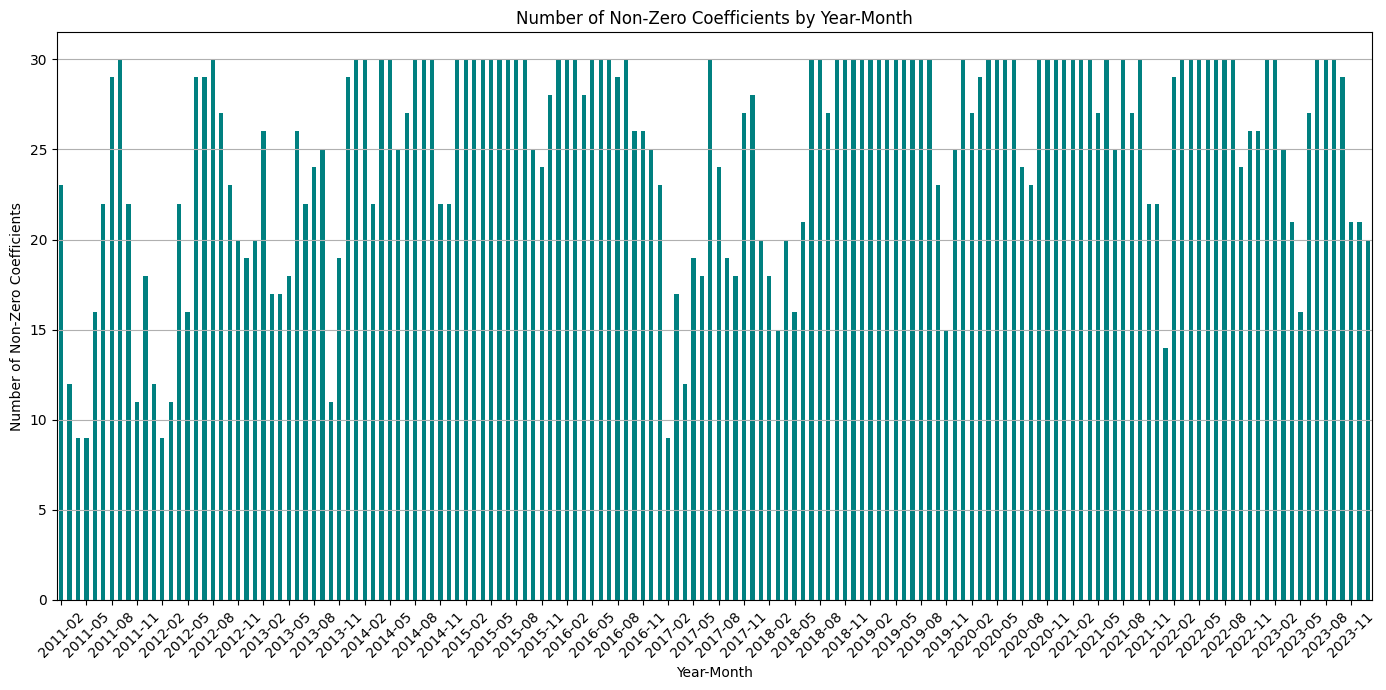

In [34]:
# Convert the 'Date' column to datetime to facilitate extraction of year and month
df['Date'] = pd.to_datetime(df['Date'])

# Filter out rows where the coefficient is 0
df_non_zero = df[df['Coefficient'] != 0]

# Create a 'YearMonth' column for grouping
df_non_zero['YearMonth'] = df_non_zero['Date'].dt.to_period('M')

# Group by the new 'YearMonth' column and count the number of coefficients in each group
coefficients_by_year_month = df_non_zero.groupby('YearMonth').size()

# Extracting the unique YearMonth values for setting the x-ticks
unique_year_months = coefficients_by_year_month.index.to_series().astype(str)

# Plotting with adjusted x-axis labels to show every third month
plt.figure(figsize=(14, 7))
coefficients_by_year_month.plot(kind='bar', color='teal')
plt.title('Number of Non-Zero Coefficients by Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Number of Non-Zero Coefficients')

# Setting x-ticks to show every third month
plt.xticks(ticks=[i for i in range(len(unique_year_months)) if i % 3 == 0], 
           labels=[label for i, label in enumerate(unique_year_months) if i % 3 == 0], 
           rotation=45)

plt.grid(axis='y')
plt.tight_layout()

plt.show()




## Features

In [35]:
# Adding 'YearMonth' to the original dataframe for grouping purposes
df['YearMonth'] = df['Date'].dt.to_period('M')

# Filtering the dataframe for coefficients different than zero
df_non_zero = df #[df['Coefficient'] != 0]

# Since the task is to select features, not necessarily aggregate them, we'll just group by 'YearMonth'
# and retain the relevant entries. The result is already in df_non_zero grouped logically by 'YearMonth'
df_non_zero_grouped = df_non_zero.groupby('YearMonth')

df_non_zero.head()


,Date,Coefficient,Feature,YearMonth
0,2011-02-01,0.060256,var_ipc_fipe,2011-02
1,2011-02-01,0.011632,var_ipca_15,2011-02
2,2011-02-01,0.054195,var_ipc_br,2011-02
3,2011-02-01,0.088374,ipca_monitor_1,2011-02
4,2011-02-01,0.097049,ipca_monitor_11,2011-02


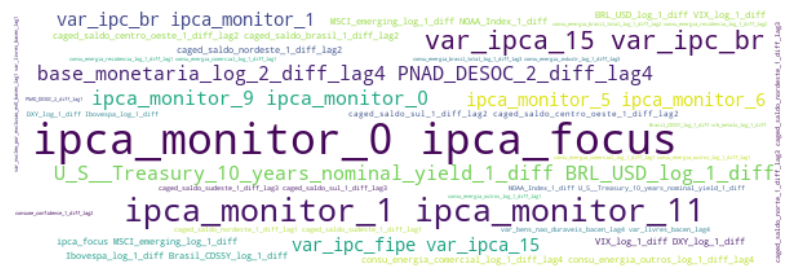

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Extracting the features with non-zero coefficients
features_non_zero = df_non_zero['Feature'].tolist()

# Joining all features into a single string for the word cloud
text = ' '.join(features_non_zero)

# Generating the word cloud
wordcloud = WordCloud(width=600, height=200, background_color='white').generate(text)

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axis for word cloud plots

# Save the word cloud as an image
plt.savefig('wordcloud_image.png', bbox_inches='tight', pad_inches=0)

plt.show()

## Features by average coefficint value

In [16]:
# Group by 'Feature' and calculate the mean of the 'Coefficient' for each feature, excluding zeros
mean_coefficients = df_non_zero.groupby('Feature')['Coefficient'].mean().reset_index()

# Sorting the results for better readability
mean_coefficients_sorted = mean_coefficients.sort_values(by='Coefficient', ascending=False).reset_index(drop=True)

mean_coefficients_sorted


,Feature,Coefficient
0,ipca_monitor_0,0.103643
1,consu_energia_outros_log_1_diff_lag2,0.092900
2,var_ipc_fipe,0.088407
3,ipca_monitor_11,0.087756
4,ipca_focus,0.084531
...,...,...
150,var_nucleo_por_exclusao_ex1_bacen_lag4,-0.049081
151,VIX_log_1_diff_lag1,-0.049414
152,var_incc_lag3,-0.062359
153,var_incc_lag1,-0.064010


### Chart showing the coefficient avarge for each variable 

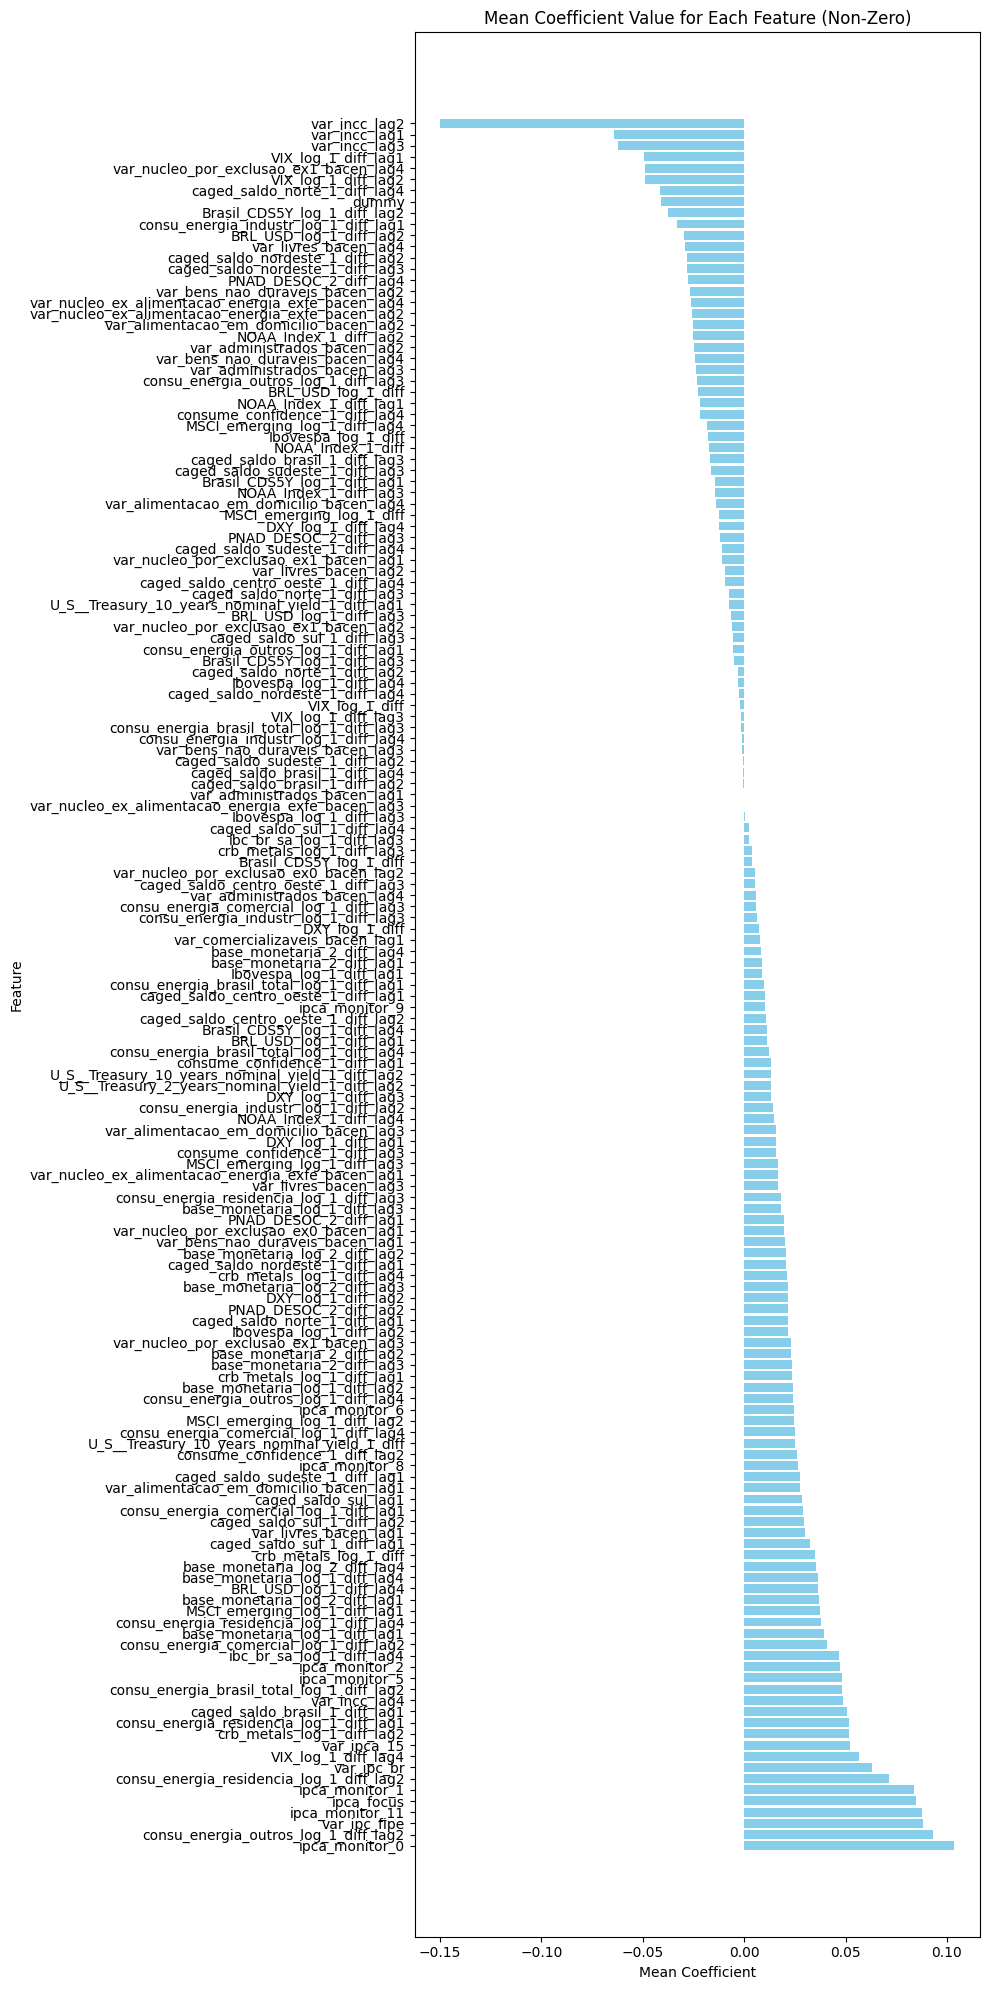

In [17]:
# Plotting the mean coefficients for all features in a horizontal bar chart
plt.figure(figsize=(10, 20))
plt.barh(mean_coefficients_sorted['Feature'], mean_coefficients_sorted['Coefficient'], color='skyblue')
plt.title('Mean Coefficient Value for Each Feature (Non-Zero)')
plt.xlabel('Mean Coefficient')
plt.ylabel('Feature')
plt.tight_layout()

plt.show()


## The most frequent features

In [18]:
# Counting the occurrences of each feature with non-zero coefficients
feature_frequencies = df_non_zero['Feature'].value_counts().reset_index()
feature_frequencies.columns = ['Feature', 'Frequency']

# Identifying the top most frequent features
top_features = feature_frequencies.head(30)

top_features.to_csv('most_frequent.csv')


## Word Cloud Top Features

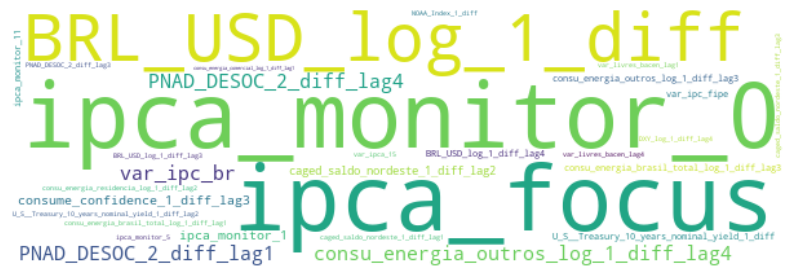

In [19]:
# Extracting the features with non-zero coefficients
features_most_frequent = top_features['Feature'].tolist()

# Joining all features into a single string for the word cloud
text = ' '.join(features_most_frequent)

# Generating the word cloud
wordcloud = WordCloud(width = 600, height = 200, background_color ='white').generate(text)

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No axis for word cloud plots
plt.show()

### The avarage coefficinet for the 20 most frequent

In [20]:
# Filtering the mean coefficients DataFrame to include only the top 30 most frequent features
top_features_mean_coefficients = mean_coefficients_sorted.merge(top_features[['Feature']], on='Feature')

# Sorting the resulting DataFrame by mean coefficient from highest to lowest
top_features_mean_coefficients_sorted = top_features_mean_coefficients.sort_values(by='Coefficient', ascending=False).reset_index(drop=True)

top_features_mean_coefficients_sorted.to_excel('mean_coefficients.xlsx')
top_features_mean_coefficients_sorted




,Feature,Coefficient
0,ipca_monitor_0,0.103643
1,var_ipc_fipe,0.088407
2,ipca_monitor_11,0.087756
3,ipca_focus,0.084531
4,ipca_monitor_1,0.083923
5,consu_energia_residencia_log_1_diff_lag2,0.071418
6,var_ipc_br,0.062890
7,var_ipca_15,0.052402
8,ipca_monitor_5,0.048060
9,BRL_USD_log_1_diff_lag4,0.036655


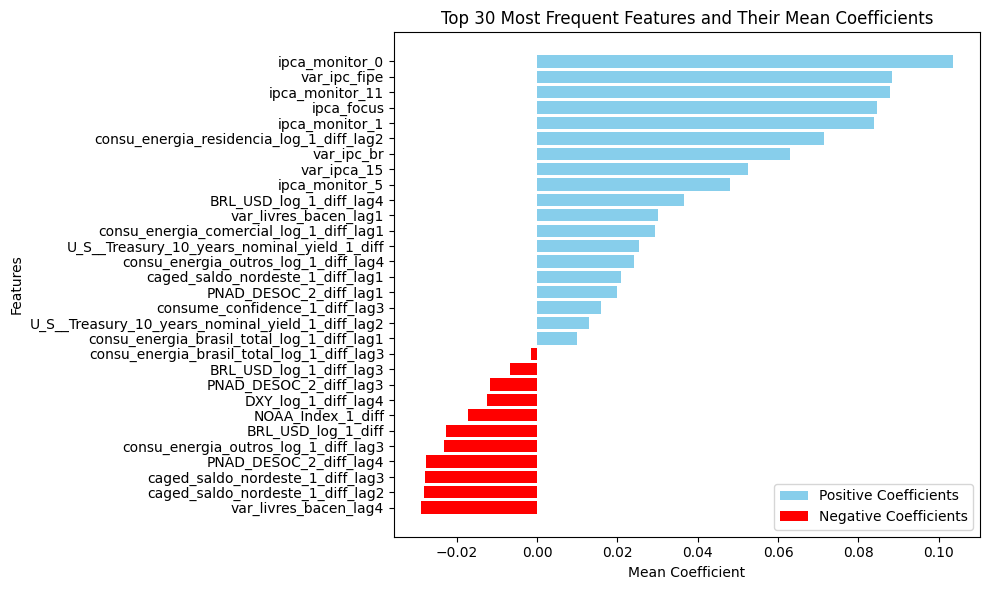

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'top_features_mean_coefficients_sorted' contains the DataFrame with top features and their mean coefficients

# Plotting the bar chart with different colors for positive and negative coefficients
plt.figure(figsize=(10, 6))
bars = plt.barh(top_features_mean_coefficients_sorted['Feature'][:30], top_features_mean_coefficients_sorted['Coefficient'][:30], color=['skyblue' if x >= 0 else 'red' for x in top_features_mean_coefficients_sorted['Coefficient'][:30]])
plt.xlabel('Mean Coefficient')
plt.ylabel('Features')
plt.title('Top 30 Most Frequent Features and Their Mean Coefficients')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest coefficient at the top

# Add a legend for positive and negative coefficients
plt.legend(handles=[bars[0], bars[-1]], labels=['Positive Coefficients', 'Negative Coefficients'])

plt.tight_layout()

# Save the plot as an image or display it
plt.savefig('mean_coefficients_bar_chart_with_colors.png')
plt.show()




## Creating a dataset with the selected features.

In [22]:

columns_to_keep = top_features_mean_coefficients_sorted['Feature']
#columns_to_keep.loc[len(columns_to_keep)] = "data"
columns_to_keep.loc[len(columns_to_keep)] = "var_ipca_bacen"
salvar = data[columns_to_keep]

salvar.to_csv("dados.csv")